https://www.kaggle.com/c/mlcourse-dota2-win-prediction/overview

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
#import ast
import time
from sklearn import linear_model

from tqdm import tqdm_notebook
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

# import json
import altair as alt
from  altair.vega import v3
from IPython.display import HTML

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [2]:
import ujson as json

In [3]:
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey

vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

### Data overview

In [4]:
train = pd.read_csv('data/train_features.csv', index_col='match_id_hash')
target = pd.read_csv('data/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('data/test_features.csv', index_col='match_id_hash')

In [5]:
target.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [6]:
target['radiant_win'].value_counts()

True     20826
False    18849
Name: radiant_win, dtype: int64

In [7]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,2,124,126,0.000000,0,0,0,0,0.000000,0,0,0,0,14,0,1,0,0,304,0,130,700,700,242.93773,1,70,156,0.000000,0,0,1,0,0.000000,0,0,0,0,59,0,0,0,1,389,4,506,399,700,326.93780,2,170,86,0.000000,0,0,0,0,0.000000,0,0,0,0,77,0,0,0,0,402,10,344,422,800,314.93780,2,120,100,0.000000,0,0,0,0,0.000000,0,0,0,0,12,0,0,1,13,982,12,780,650,720,386.93787,3,82,170,0.000000,0,0,1,0,1.00,0,0,0,0,21,0,0,0,6,788,9,706,640,640,422.93790,3,174,90,0.000000,0,0,2,0,0.00,0,0,0,0,60,0,0,0,1,531,0,307,720,720,242.93773,2,180,84,0.299948,0,0,2,0,0.00,0,0,0,0,84,1,0,0

In [35]:
print(f'Number of samples in train: {train.shape[0]}')
print(f'Number of columns in train: {train.shape[1]}')
for col in train.columns:
    if train[col].isnull().any():
        print(col, train[col].isnull().sum())

Number of samples in train: 39675
Number of columns in train: 246


In [37]:
train['game_mode'].value_counts()

22    31762
4      3564
23     2546
3      1200
2       408
5       188
12        5
16        2
Name: game_mode, dtype: int64

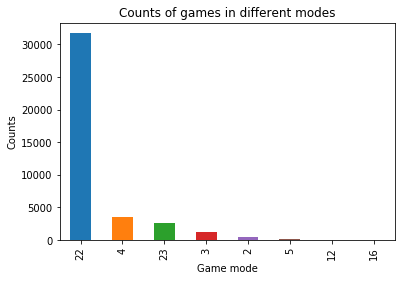

In [11]:
ax = train['game_mode'].value_counts().plot(kind='bar', title='Counts of games in different modes');
ax.set_xlabel("Game mode");
ax.set_ylabel("Counts");

In [12]:
train_modes = train['game_mode'].value_counts().reset_index().rename(columns={'index': 'game_mode', 'game_mode': 'count'})
train_modes

,game_mode,count
0,22,31762
1,4,3564
2,23,2546
3,3,1200
4,2,408
5,5,188
6,12,5
7,16,2


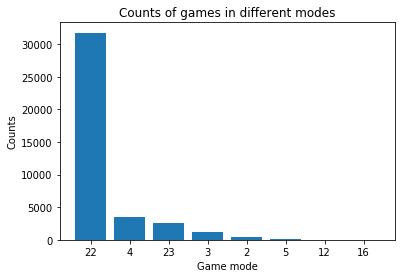

In [13]:
plt.bar(range(len(train_modes['game_mode'])), train_modes['count']);
plt.xticks(range(len(train_modes['game_mode'])), train_modes['game_mode']);
plt.xlabel('Game mode');
plt.ylabel('Counts');
plt.title('Counts of games in different modes');

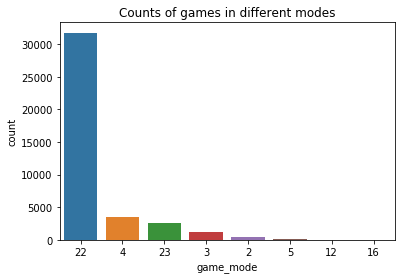

In [14]:
sns.countplot(data=train, x='game_mode', order=train['game_mode'].value_counts().index);
plt.title('Counts of games in different modes');

In [15]:
train_modes['game_mode'] = train_modes['game_mode'].astype(str)
data=[go.Bar(
    x=train_modes['game_mode'],
    y=train_modes['count'],
    name='Game mode'
)]

layout = go.Layout(title='Counts of games in different modes',
                  xaxis=dict(title='Game mode'),
                  yaxis=dict(title='Count'))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='bar')

In [16]:
render(alt.Chart(train_modes).mark_bar().encode(
    x=alt.X("game_mode:N", axis=alt.Axis(title='Game modes'), sort=list(train_modes['game_mode'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['game_mode', 'count']
).properties(title="Counts of games in different modes", width=400).interactive())

In [17]:
train['radiant_win'] = target['radiant_win']

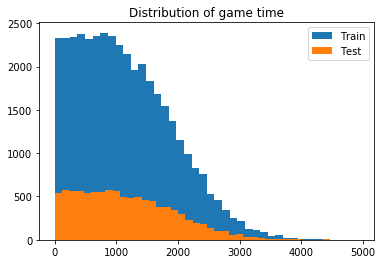

In [18]:
plt.hist(train['game_time'], bins=40, label='Train');
plt.hist(test['game_time'], bins=40, label='Test');
plt.title('Distribution of game time');
plt.legend();

We can see that the distribution of game time in train and test data is quite similar.

In [19]:
train_games = alt.Chart(train_modes).mark_bar().encode(
    x=alt.X("game_mode:N", axis=alt.Axis(title='Game modes'), sort=list(train_modes['game_mode'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['game_mode', 'count']
).properties(title="Counts of games in different modes in train data", width=400).interactive()

test_modes = test['game_mode'].value_counts().reset_index().rename(columns={'index': 'game_mode', 'game_mode': 'count'})
test_games = alt.Chart(test_modes).mark_bar().encode(
    x=alt.X("game_mode:N", axis=alt.Axis(title='Game modes'), sort=list(train_modes['game_mode'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['game_mode', 'count']
).properties(title="Counts of games in different modes in test data", width=400).interactive()

d = train.groupby(['game_mode', 'radiant_win'])['game_time'].count().reset_index().rename(columns={'game_time': 'count'})
train_r = alt.Chart(d).mark_bar().encode(
    x=alt.X("radiant_win:N", axis=alt.Axis(title='Radiant win'), sort=list(train_modes['game_mode'].values)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    column='game_mode',
    color='radiant_win:N',
    tooltip=['game_mode', 'radiant_win', 'count']
).properties(title="Counts of wins and losses by game mode", width=100).interactive()

render(train_games | test_games)

In [20]:
render(train_r)

First thing worth noticing - there are 8 game modes in train data and only 7 games in test data. But the game mode 16 in train data has only 2 samples, so we can combine it with other game types. Otherwise the distribution of game modes seems similar.

Wins and losses are more or less equally distributed over game modes.

### Player features
Here we have features for separate players. Let's have a look at the distribution of one of them.

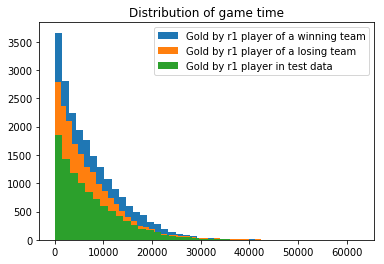

In [21]:
plt.hist(train.loc[train['radiant_win'] == True, 'r1_gold'], bins=40, label='Gold by r1 player of a winning team');
plt.hist(train.loc[train['radiant_win'] == False, 'r1_gold'], bins=40, label='Gold by r1 player of a losing team');
plt.hist(test['r1_gold'], bins=40, label='Gold by r1 player in test data');
plt.title('Distribution of game time');
plt.legend();

Nothing interesting... as it should be expected! This feature shows gold earned by a first player. Of course distributions of this feature in train and test should be similar, as first player is chosen randomly.

Let's build a first model on the existing features and look at its quality.

# 1 First model

In [22]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

Training function

In [23]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        print(train_index, valid_index)
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. AUC: {score:.4f}.') #
            print('') #
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [41]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': 20,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'bagging_seed' : 42,
          'objective': 'binary'
         }

In [43]:
# https://www.kaggle.com/shokhan/lightgbm-starter-code - CELL 14
param = {
        'boost': 'gbdt',
    
        'bagging_freq': 5,  #handling overfitting
        'bagging_fraction': 0.5,  #handling overfitting - adding some noise
        'boost_from_average':'false',
        'feature_fraction': 0.05, #handling overfitting
        'learning_rate': 0.01,  #the changes between one auc and a better one gets really small thus a small learning rate performs better
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 10,
        'num_threads': 5,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }

Fold 0 started at Thu Apr 18 12:06:47 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.871492	valid_1's auc: 0.801783
[2000]	training's auc: 0.9164	valid_1's auc: 0.808636
[3000]	training's auc: 0.947942	valid_1's auc: 0.811622
[4000]	training's auc: 0.968687	valid_1's auc: 0.812984
[5000]	training's auc: 0.981789	valid_1's auc: 0.813686
[6000]	training's auc: 0.989784	valid_1's auc: 0.814289
[7000]	training's auc: 0.994476	valid_1's auc: 0.814728
Early stopping, best iteration is:
[7714]	training's auc: 0.996635	valid_1's auc: 0.815097
Fold 1 started at Thu Apr 18 12:07:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.873833	valid_1's auc: 0.790416
[2000]	training's auc: 0.918218	valid_1's auc: 0.796412
[3000]	training's auc: 0.949392	valid_1's auc: 0.799156
[4000]	training's auc: 0.969524	valid_1's auc: 0.800527
[5000]	training's auc: 0.982465	valid_1's auc: 0.801479
Early stopping, best iterat

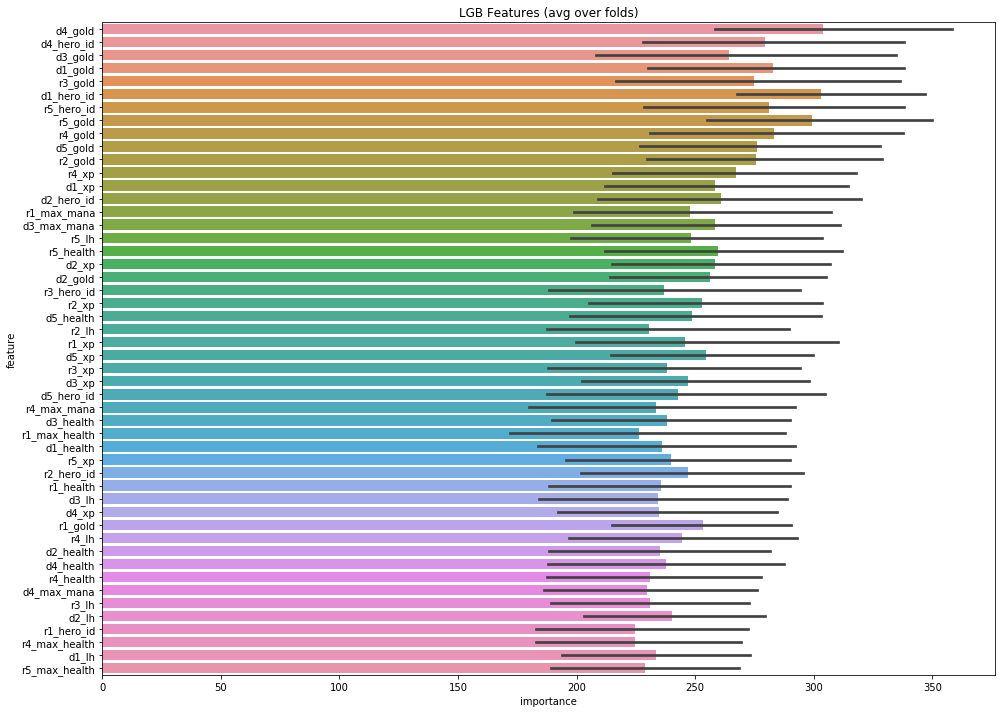

In [44]:
%%time
X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = train['radiant_win']
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

So this was our baseline model. We can see that features in top-50 show variuos aspects of player activity, but gold and health are prevalent. Let's get started with feature engineering.

### Feature engineering on basic data
My idea behind this FE is the following: Let's take gold, for example. Gold earned by each player can't give us a lot of information. But what is we take total gold by the team? Maybe teams with more gold earned usually win. What if we take mean and std of players' gold in a team? Maybe teams where players tend to have similar parameters are more likely to win. Let's try creating these features.

In [45]:
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 
          'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 
          'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation',
          'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
    
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train['r_total_' + c] = train[r_columns].sum(1)
    train['d_total_' + c] = train[d_columns].sum(1)
    train['total_' + c + '_ratio'] = train['r_total_' + c] / train['d_total_' + c]
    
    test['r_total_' + c] = test[r_columns].sum(1)
    test['d_total_' + c] = test[d_columns].sum(1)
    test['total_' + c + '_ratio'] = test['r_total_' + c] / test['d_total_' + c]
    
    train['r_std_' + c] = train[r_columns].std(1)
    train['d_std_' + c] = train[d_columns].std(1)
    train['std_' + c + '_ratio'] = train['r_std_' + c] / train['d_std_' + c]
    
    test['r_std_' + c] = test[r_columns].std(1)
    test['d_std_' + c] = test[d_columns].std(1)
    test['std_' + c + '_ratio'] = test['r_std_' + c] / test['d_std_' + c]
    
    train['r_mean_' + c] = train[r_columns].mean(1)
    train['d_mean_' + c] = train[d_columns].mean(1)
    train['mean_' + c + '_ratio'] = train['r_mean_' + c] / train['d_mean_' + c]
    
    test['r_mean_' + c] = test[r_columns].mean(1)
    test['d_mean_' + c] = test[d_columns].mean(1)
    test['mean_' + c + '_ratio'] = test['r_mean_' + c] / test['d_mean_' + c]

In [46]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win,r_total_kills,d_total_kills,total_kills_ratio,r_std_kills,d_std_kills,std_kills_ratio,r_mean_kills,d_mean_kills,mean_kills_ratio,r_total_deaths,d_total_deaths,total_deaths_ratio,r_std_deaths,d_std_deaths,std_deaths_ratio,r_mean_deaths,d_mean_deaths,mean_deaths_ratio,r_total_assists,d_total_assists,total_assists_ratio,r_std_assists,d_std_assists,std_assists_ratio,r_mean_assists,d_mean_assists,mean_assists_ratio,r_total_denies,d_total_denies,total_denies_ratio,r_std_denies,d_std_denies,std_denies_ratio,r_mean_denies,d_mean_denies,mean_denies_ratio,r_total_gold,d_total_gold,total_gold_ratio,r_std_gold,d_std_gold,std_gold_ratio,r_mean_gold,d_mean_gold,mean_gold_ratio,r_total_lh,d_total_lh,total_lh_ratio,r_std_lh,d_std_lh,std_lh_ratio,r_mean_lh,d_mean_lh,mean_lh_ratio,r_total_xp,d_total_xp,total_xp_ratio,r_std_xp,d_std_xp,std_xp_ratio,r_mean_xp,d_mean_xp,mean_xp_ratio,r_total_health,d_total_health,total_health_ratio,r_std_health,d_std_health,s

In [47]:
train.shape

(39675, 453)

Fold 0 started at Tue Apr 16 22:33:33 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.885145	valid_1's auc: 0.826092
[2000]	training's auc: 0.932732	valid_1's auc: 0.82758
Early stopping, best iteration is:
[2051]	training's auc: 0.934676	valid_1's auc: 0.827703
Fold 1 started at Tue Apr 16 22:33:55 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.88701	valid_1's auc: 0.813216
[2000]	training's auc: 0.933416	valid_1's auc: 0.815261
Early stopping, best iteration is:
[2307]	training's auc: 0.944078	valid_1's auc: 0.815696
Fold 2 started at Tue Apr 16 22:34:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.884356	valid_1's auc: 0.827115
[2000]	training's auc: 0.931339	valid_1's auc: 0.828838
Early stopping, best iteration is:
[2381]	training's auc: 0.944868	valid_1's auc: 0.829354
Fold 3 started at Tue Apr 16 22:34:38 2019
Training until validation scores

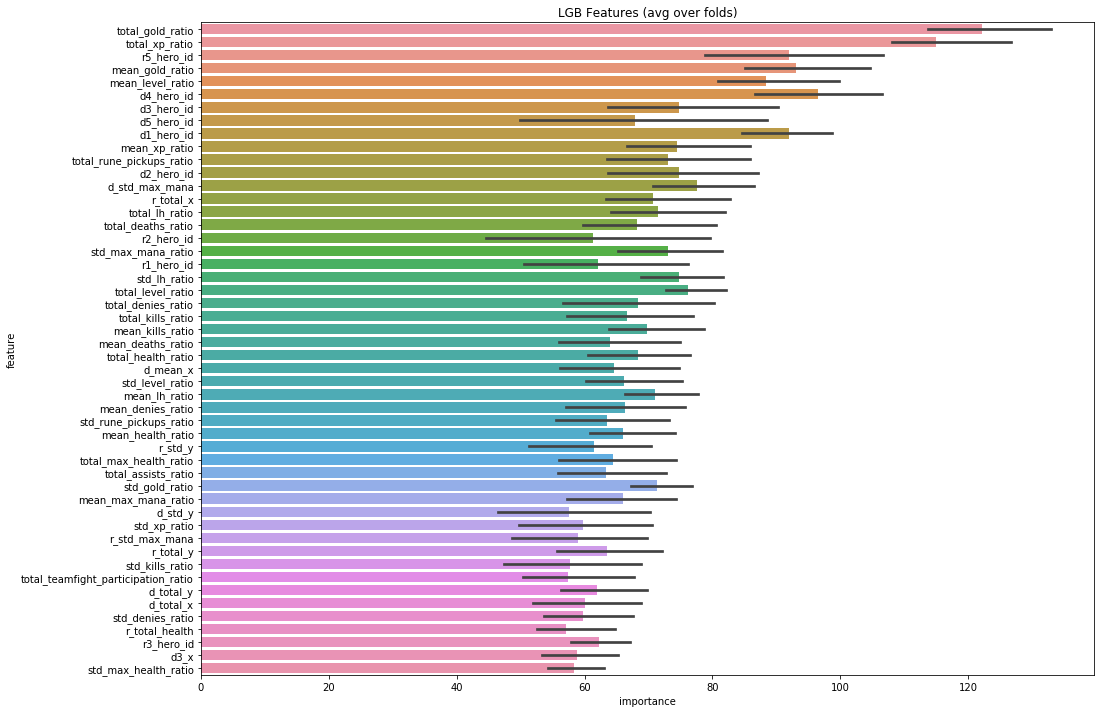

In [48]:
%%time
X = train.drop(['radiant_win'], axis=1).reset_index(drop=True)
y = train['radiant_win']
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

As we can see, the score increased substantially thanks to the new features. Surprisingly hero id is still one of the top features.

But we used only the features from the basic features. Let's try working with json data to get more cool data!

### Working with json data¶
I'll use functions from this kernel: https://www.kaggle.com/kashnitsky/dota-2-win-prediction-random-forest-starter

In [50]:
with open(os.path.join('data/', 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

The match object is now a big Python dictionary. In **match['players']** we have a description of each player.

In [55]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [87]:
player = match['players'][1]
print(len(player['times']))

40


In [95]:
player

{'player_slot': 1,
 'hero_id': 86,
 'hero_name': 'npc_dota_hero_rubick',
 'account_id_hash': 'ca3c22fe0645a95875cd9bd86b759959',
 'ability_upgrades': [{'ability': 5448, 'time': 251, 'level': 1},
  {'ability': 5450, 'time': 287, 'level': 2},
  {'ability': 5450, 'time': 484, 'level': 3},
  {'ability': 5448, 'time': 636, 'level': 4},
  {'ability': 5448, 'time': 921, 'level': 5},
  {'ability': 5452, 'time': 1098, 'level': 6},
  {'ability': 5450, 'time': 1196, 'level': 7},
  {'ability': 5448, 'time': 1380, 'level': 8},
  {'ability': 5451, 'time': 1448, 'level': 9},
  {'ability': 5451, 'time': 1508, 'level': 10},
  {'ability': 5450, 'time': 1520, 'level': 11},
  {'ability': 5452, 'time': 1718, 'level': 12},
  {'ability': 5959, 'time': 1736, 'level': 13},
  {'ability': 6003, 'time': 1921, 'level': 14},
  {'ability': 5451, 'time': 1922, 'level': 15},
  {'ability': 5451, 'time': 2136, 'level': 16}],
 'obs_placed': 4,
 'sen_placed': 2,
 'creeps_stacked': 0,
 'camps_stacked': 0,
 'rune_pickups': 

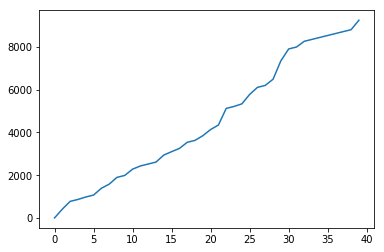

In [94]:
plt.plot(player['gold_t']);

## players
@yorko has already extracted a lot of features from players data, but let's try to add more. Here is the list of additional features:

max ability level,
max_hero_hit,
amount of purchases,
count of abilities used,
total damage dealt,
total damage received,

In [96]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

#### How to build initial features from scratch
Now we diclose the code that we used to build initial features train_features.csv and test_features.csv. You can modify the following code to add more features.

In a nutshell:

1. ***extract_features_csv(match)*** extracts features from game descriptions and writes them into a dictionary
2. ***extract_targets_csv(match, targets)*** extracts the target variable radiant_win
3. iterating through the file with raw data, we collect all features
4. with ***pandas.DataFrame.from_records()*** we create dataframes with new features

In [99]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    #('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    #('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    #'x', #### ?
    #'y', #### ?
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

In [ ]:
def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))
            
    return collections.OrderedDict(row)

In [101]:
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

### Составляем новые train & targets

In [100]:
%%time
PATH_TO_DATA = 'data/'
train_new_features = []
train_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    train_new_features.append(features)
    train_new_targets.append(targets)
    
train_new_features = pd.DataFrame.from_records(train_new_features).set_index('match_id_hash')
train_new_targets = pd.DataFrame.from_records(train_new_targets).set_index('match_id_hash')


Wall time: 1min 9s


### Составляем новые test

In [103]:
test_new_features = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'test_matches.jsonl')):
    
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    test_new_features.append(features)
    
test_new_features = pd.DataFrame.from_records(test_new_features).set_index('match_id_hash')

In [104]:
train_new_features.shape

(39675, 305)

In [105]:
%%time
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed', 'ability_level', 'max_hero_hit', 'purchase_count',
          'count_ability_use', 'damage_dealt', 'damage_received']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train_new_features['r_total_' + c] = train_new_features[r_columns].sum(1)
    train_new_features['d_total_' + c] = train_new_features[d_columns].sum(1)
    train_new_features['total_' + c + '_ratio'] = train_new_features['r_total_' + c] / train_new_features['d_total_' + c]
    
    test_new_features['r_total_' + c] = test_new_features[r_columns].sum(1)
    test_new_features['d_total_' + c] = test_new_features[d_columns].sum(1)
    test_new_features['total_' + c + '_ratio'] = test_new_features['r_total_' + c] / test_new_features['d_total_' + c]
    
    train_new_features['r_std_' + c] = train_new_features[r_columns].std(1)
    train_new_features['d_std_' + c] = train_new_features[d_columns].std(1)
    train_new_features['std_' + c + '_ratio'] = train_new_features['r_std_' + c] / train_new_features['d_std_' + c]
    
    test_new_features['r_std_' + c] = test_new_features[r_columns].std(1)
    test_new_features['d_std_' + c] = test_new_features[d_columns].std(1)
    test_new_features['std_' + c + '_ratio'] = test_new_features['r_std_' + c] / test_new_features['d_std_' + c]
    
    train_new_features['r_mean_' + c] = train_new_features[r_columns].mean(1)
    train_new_features['d_mean_' + c] = train_new_features[d_columns].mean(1)
    train_new_features['mean_' + c + '_ratio'] = train_new_features['r_mean_' + c] / train_new_features['d_mean_' + c]
    
    test_new_features['r_mean_' + c] = test_new_features[r_columns].mean(1)
    test_new_features['d_mean_' + c] = test_new_features[d_columns].mean(1)
    test_new_features['mean_' + c + '_ratio'] = test_new_features['r_mean_' + c] / test_new_features['d_mean_' + c]

In [109]:
train_new_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_dealt,r3_damage_received,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r4_ability_level,r4_max_hero_hit,r4_purchase_count,r4_count_ability_use,r4_damage_dealt,r4_damage_received,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,r5_ability_level,r5_max_hero_hit,r5_purchase_count,r5_count_ability_use,r5_damage_dealt,r5_damage_received,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d1_ability_level,d1_max_hero_hit,d1_purchase_count,d1_count_ability_use,d1_damage_dealt,d1_damage_received,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d2_ability_level,d2_max_hero_hit,d2_purchase_count,d2_count_ability_use,d2_damage_dealt,d2_damage_received,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d3_ability_level,d3_max_hero_hit,d3_purchase_count,d3_count_ability_use,d3_damage_dealt,d3_damage_received,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d4_ability_level,d4_max_hero_hit,d4_purchase_count,d4_count_ability_use,d4_damage_dealt,d4_damage_received,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d

In [108]:
train_new_features.shape

(39675, 566)

Now let's try building a new model!

Fold 0 started at Tue Apr 16 22:44:42 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.890551	valid_1's auc: 0.825874
Early stopping, best iteration is:
[1761]	training's auc: 0.930398	valid_1's auc: 0.827564
Fold 1 started at Tue Apr 16 22:45:01 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.891763	valid_1's auc: 0.814007
[2000]	training's auc: 0.940142	valid_1's auc: 0.816245
[3000]	training's auc: 0.970428	valid_1's auc: 0.817131
Early stopping, best iteration is:
[3103]	training's auc: 0.972771	valid_1's auc: 0.817342
Fold 2 started at Tue Apr 16 22:45:33 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.889733	valid_1's auc: 0.82753
[2000]	training's auc: 0.939196	valid_1's auc: 0.829374
Early stopping, best iteration is:
[2290]	training's auc: 0.949619	valid_1's auc: 0.829691
Fold 3 started at Tue Apr 16 22:45:58 2019
Training until validation score

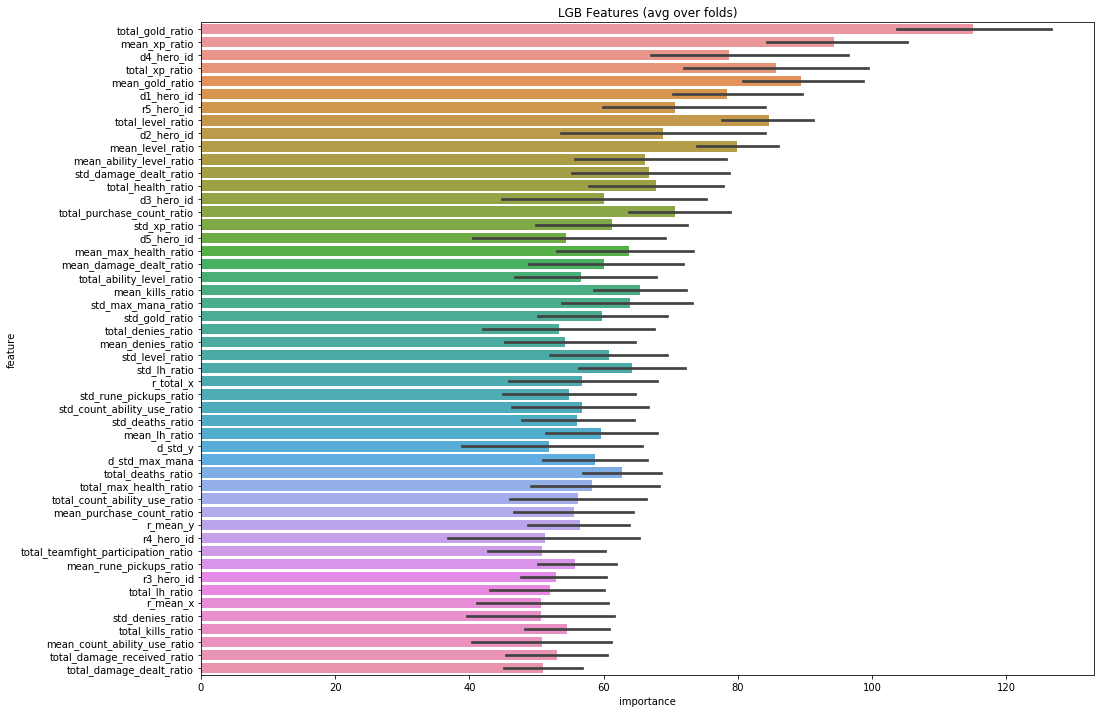

In [62]:
%%time
X = train_new_features.reset_index(drop=True)
X_test = test_new_features.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [67]:
sub = pd.read_csv('data/sample_submission.csv')
sub['radiant_win_prob'] = prediction_lgb
sub.to_csv('data/submission.csv', index=False)
sub.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.489269
1,70e5ba30f367cea48793b9003fab9d38,0.987347
2,4d9ef74d3a2025d79e9423105fd73d41,0.974595
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.766301
4,bec17f099b01d67edc82dfb5ce735a43,0.408630


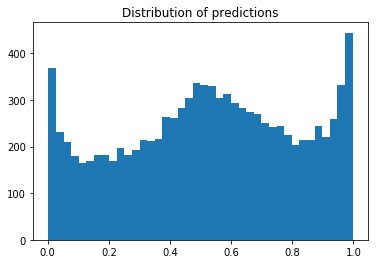

In [65]:
plt.hist(prediction_lgb, bins=40);
plt.title('Distribution of predictions');

## Submission File

In [ ]:
df_submission = pd.DataFrame({'radiant_win_prob': predictions}, 
                                 index=df_test_features.index)
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

https://lightgbm.readthedocs.io/en/latest/Python-API.html
https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
https://xgboost.readthedocs.io/en/latest/parameter.html
